# Load necessary libraries



In [ ]:
# Necessary libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import seaborn as sns

# For Evalution

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For Model Building

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# For graph
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
#Disble the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [ ]:
data = pd.read_csv('/content/BTC.csv')
data.rename(columns = {'date' : 'timestamp'}, inplace = True)
print("Data shape: ", data.shape, "\n")
data.tail(5)

Data shape:  (4890, 5) 



,timestamp,open,high,low,close
4885,2023-12-01,37791.6,38865.5,37686.9,38787.0
4886,2023-12-02,38765.0,38912.3,38688.3,38912.3
4887,2023-12-03,39345.4,39760.3,39345.4,39560.1
4888,2023-12-04,39543.8,42008.5,39543.8,41736.9
4889,2023-12-05,41903.1,43717.9,41528.8,43717.9


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4890 non-null   object 
 1   open       4890 non-null   float64
 2   high       4890 non-null   float64
 3   low        4890 non-null   float64
 4   close      4890 non-null   float64
dtypes: float64(4), object(1)
memory usage: 191.1+ KB


In [ ]:
data.describe()

,open,high,low,close
count,4890.000000,4890.000000,4890.000000,4890.000000
mean,9921.949144,10174.460382,9648.691588,9931.084352
std,14852.229693,15228.033430,14433.749765,14859.476182
min,0.049510,0.049510,0.010000,0.049510
25%,220.382500,226.775000,212.302500,220.705000
50%,1188.765000,1215.970000,1150.225000,1189.050000
75%,11549.550000,11861.075000,11271.700000,11574.650000
max,67304.600000,68976.500000,66343.000000,67305.100000


# Check for NULL values

In [ ]:
print('Null Values:',data.isnull().values.sum(),)
print('NA values:',data.isnull().values.any(),"\n")
data=data.dropna()
print('Null Values:',data.isnull().values.sum())
print('NA values:',data.isnull().values.any())


Null Values: 0
NA values: False 

Null Values: 0
NA values: False


# Exploratory Data Analysis

In [ ]:
def get_records_in_interval(data, start_date, end_date, date_column='timestamp'):
    data[date_column] = pd.to_datetime(data[date_column])

    mask = (data[date_column] >= start_date) & (data[date_column] <= end_date)
    return data.loc[mask]

subset_2022 = get_records_in_interval(data, "2022-1-1", "2022-12-31")
subset_2022.sample(5)

,timestamp,open,high,low,close
4373,2022-07-07,20332.5,21820.7,20249.9,21654.4
4299,2022-04-24,39903.0,39948.0,39138.1,39641.3
4209,2022-01-24,35515.6,37471.4,32971.8,36382.2
4313,2022-05-08,35200.6,35711.2,33723.1,34450.4
4416,2022-08-19,23362.4,23402.9,20999.2,21024.6


In [ ]:
f= plt.figure(figsize=(8,10))

def plot_bitcoin_close_price(data):

    data['timestamp'] = pd.to_datetime(data['timestamp'])

    fig = go.Figure(data=go.Scatter(x=data['timestamp'], y=data['close'], mode='lines'))

    fig.update_layout(title='Bitcoin Closing Price Over Time',
                      xaxis_title='Timestamp',
                      yaxis_title='Close Price (USD)',
                      xaxis_rangeslider_visible=True)

    fig.show()

plot_bitcoin_close_price(get_records_in_interval(data, "2017-1-1", "2023-12-6"))

<Figure size 800x1000 with 0 Axes>

In [ ]:
subset_dec2023 = get_records_in_interval(data, "2023-06-01", "2023-12-06")
def c_chart(data, label):
    candlestick = go.Figure(data=[go.Candlestick(x=data['timestamp'],
                                                open=data['open'],
                                                high=data['high'],
                                                low=data['low'],
                                                close=data['close'],
                                                 )])
    candlestick.update_xaxes(title_text='Time', rangeslider_visible=True)
    candlestick.update_layout(title={'text': '{:} Candelstick Chart'.format(label),
                                     "y": 0.8,
                                     "x": 0.5,
                                     'xanchor': 'center',
                                     'yanchor': 'top'})
    candlestick.update_yaxes(title_text='Price in USD', ticksuffix='$')
    return candlestick

%matplotlib inline
btc_candle = c_chart(subset_dec2023, label="BTC price")
btc_candle.show()

# Build LSTM Model


In [ ]:
close_df = data[['timestamp','close']]
print("Shape of close data frame: ", close_df.shape)

Shape of close data frame:  (4890, 2)


In [ ]:
# Get close subset from 2023 until present
close_subset = get_records_in_interval(close_df, '2023-01-01', "2023-12-05")
print("\nTotal data for prediction: ",close_subset.shape[0])
close_subset


Total data for prediction:  339


,timestamp,close
4551,2023-01-01,16594.6
4552,2023-01-02,16692.9
4553,2023-01-03,16670.7
4554,2023-01-04,16821.5
4555,2023-01-05,16832.7
...,...,...
4885,2023-12-01,38787.0
4886,2023-12-02,38912.3
4887,2023-12-03,39560.1
4888,2023-12-04,41736.9


In [ ]:
# Plot data to train model
plot_bitcoin_close_price(close_subset)

In [ ]:
# Normalizing data
origin_close_subset = close_subset.copy()
del close_subset['timestamp']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(close_subset).reshape(-1,1))
print(closedf.shape)

(339, 1)


In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (203, 1)
test_data:  (136, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (187, 15)
y_train:  (187,)
x_test:  (120, 15)
y_test (120,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1] , 1)

print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)

x_train:  (187, 15, 1)
x_test:  (120, 15, 1)


In [ ]:
# Model building

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [ ]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
6/6 [==============================] - 2s 57ms/step - loss: 0.0912 - val_loss: 0.1635
Epoch 2/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0743 - val_loss: 0.1346
Epoch 3/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0582 - val_loss: 0.1084
Epoch 4/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0440 - val_loss: 0.0845
Epoch 5/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0315 - val_loss: 0.0627
Epoch 6/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0207 - val_loss: 0.0422
Epoch 7/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0119 - val_loss: 0.0258
Epoch 8/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0142
Epoch 9/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 10/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 11/200
6/6 [=

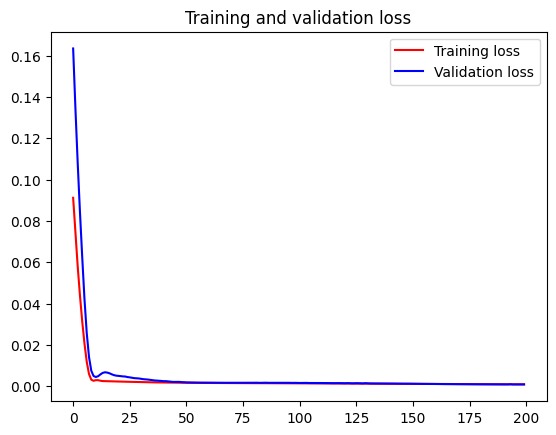

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
# Do prediction and check performance metrics
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict.shape, test_predict.shape

4/4 [==============================] - 0s 4ms/step


((187, 1), (120, 1))

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [ ]:
# Evaluation metrices RMSE and MAE

print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("\n-------------------------------------------------------------------------------------\n")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  831.7466123005604
Train data MSE:  691802.4270734587
Train data MAE:  614.6579963235295

-------------------------------------------------------------------------------------

Test data RMSE:  813.4087659169694
Test data MSE:  661633.8204705671
Test data MAE:  546.048173828125


In [ ]:
# Variance Regression Score
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9199347213735534
Test data explained variance regression score: 0.9697396850970103


In [ ]:
# R square for regression

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9193822954499461
Test data R2 score: 0.9694421949065962


In [ ]:
close_subset = get_records_in_interval(close_df, '2022-01-01', "2023-12-05")

# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting

testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'timestamp': origin_close_subset['timestamp'],
                       'original_close': origin_close_subset['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['timestamp'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (339, 1)
Test predicted data:  (339, 1)
